# RNNs

In this section, you will implement a simple Recurrent Neural Network (RNN) from scratch to perform sequence prediction using the IMDb movie reviews dataset.

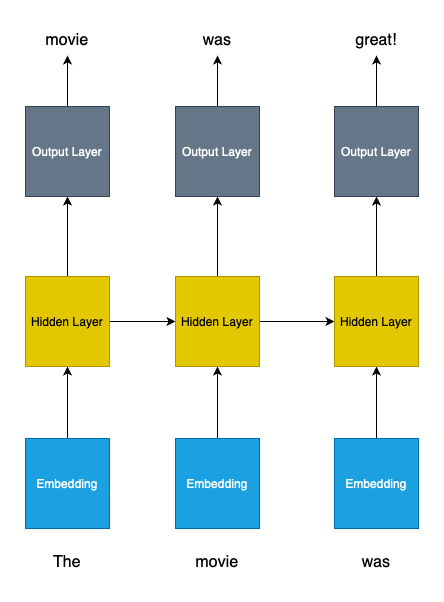

In [ ]:
import numpy as np
import gensim.downloader as api
from gensim.models import FastText, KeyedVectors
from tqdm import tqdm

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import pandas as pd

#### Load and Prepare Data

Next, we load the IMDb dataset and prepare it for training.

In [ ]:
vocab_size = 1000
maxlen = 100

In [ ]:
(x_train, _), (x_test, _) = imdb.load_data(num_words=vocab_size + 3, maxlen=maxlen)

In [ ]:
# Create a one-hot encoded representation of the training data
x_train_one_hot_encoded = np.zeros((x_train.shape[0], maxlen, vocab_size))

# Iterate over each sample and each word index to set the one-hot value to 1
for i in range(x_train.shape[0]):
    for j in range(len(x_train[i])):
        idx = x_train[i][j] - 3
        if idx < 0:
          idx = 0
        x_train_one_hot_encoded[i, j, idx] = 1

In [ ]:
# Decode the dataset back into words to train Word2Vec
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items() if v < vocab_size}

x_train_words = [[index_word.get(idx-3, "unk") for idx in sequence] for sequence in x_train]
x_test_words = [[index_word.get(idx-3, "unk") for idx in sequence] for sequence in x_test]

In [ ]:
embedding_model = api.load("glove-twitter-50")
embedding_size = embedding_model.vector_size

In [ ]:
def embed_sequences(sequences, embedding_model, maxlen, embedding_size):
    embeddings = []
    for sequence in sequences:
        seq_embedding = [
            embedding_model[word] if word in embedding_model else np.zeros(embedding_size)
            for word in sequence
        ]
        if len(seq_embedding) < maxlen:
            # Padding with zero vectors if sequence is shorter
            seq_embedding += [np.zeros(embedding_size)] * (maxlen - len(seq_embedding))
        if len(seq_embedding) > maxlen:
            seq_embedding = seq_embedding[:maxlen]

        embeddings.append(seq_embedding)
    return np.array(embeddings)

In [ ]:
x_train_embeddings = embed_sequences(x_train_words, embedding_model, maxlen, embedding_size)
y_train_outputs = x_train_one_hot_encoded

# Get correct values for next word prediction
x_train_embeddings = x_train_embeddings[:, :maxlen - 1, :]
y_train_outputs = y_train_outputs[:, -(maxlen - 1):, :]

#### Softmax Function

In [ ]:
def softmax(x: np.ndarray) -> np.ndarray:
    return np.exp(x) / np.sum(np.exp(x))

#### Input Layer Class

Define the InputLayer class. The input player includes the following variables:   This variable represents the weight matrix connecting the input layer to the hidden layer. The dimensions are defined by the hidden size and the size of the input at each time step. It is initialized with small random values to facilitate learning during training.

Variables:
- `inputs`: The input sequences for the RNN, which are encoded using word2vec. It has a shape of (max_sequence_length, word2vec_size).
- `weights`: This weight matrix connecting the input layer to the hidden layer.
- `delta_weights`: The accumulation of the weight matrix gradients calculated across timesteps during backpropogation.

You must implement the following functions:
- `forward`: Multiply the input by the weight matrix. The output is a weighted sum that will be passed to the hidden layer for further processing.

- `backward`: Calculate the gradient of the forward operation and add that value to `self.delta_weights`, to be updated in `update_parameters`.



In [ ]:
class InputLayer:
    inputs: np.ndarray
    weights: np.ndarray = None
    delta_weights: np.ndarray = None

    def __init__(self, inputs: np.ndarray, hidden_size: int) -> None:
        self.inputs = inputs

        limit = np.sqrt(6 / (len(inputs[0]) + hidden_size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(hidden_size, len(inputs[0])))

        self.delta_weights = np.zeros_like(self.weights)

    def __reset_deltas__(self):
        self.delta_weights = np.zeros_like(self.weights)

    def get_input(self, time_step: int) -> np.ndarray:
        return self.inputs[time_step][:, np.newaxis]

    def forward(self, time_step: int) -> np.ndarray:
        return self.weights @ self.get_input(time_step)

    def backward(
        self, time_step: int, delta_weights: np.ndarray
    ) -> None:

        self.delta_weights +=  np.dot(delta_weights, self.get_input(time_step).T)
        # self.delta_weights += delta_weights

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights

        self.__reset_deltas__()

#### Hidden Layer Class

Define the HiddenLayer class. The hidden layer maintains the hidden states across time steps and computes the activations based on the weighted sum of the inputs, computed in the input layer, and the previous hidden state.

variables:
- `states`: The hidden states for all time steps during the sequence processing. It has a shape of (max_num_time_steps, hidden_size, 1).

- `weights`: The weight matrix connecting the previous hidden layer.

- `bias`: The bias vector added to the weighted sum of inputs and hidden states.

- `delta_weights`: The accumulation of gradients of the weight matrix computed during backpropogation.

- `delta_bias`: The accumulation of gradients of the bias vector computed during backpropogation.

- `next_delta_hidden_state_activation`: The gradient of the previously calculated hidden state activation.


You must implement the following functions:

- `forward`: This function computes the forward pass through the hidden layer. It combines the weighted input, the previous hidden state, and the bias, followed by applying the hyperbolic tangent activation function (tanh). The resulting activation is stored and returned for further processing. Be sure to update the hidden state using `set_hidden_state`.

- `backward`: This function computes the gradients for backpropagation. It calculates the delta for the activation using the incoming delta_output, propagates the gradients back to the previous hidden state, and updates delta_weights and delta_bias based on the computed gradients.

In [ ]:
class HiddenLayer:
    states: np.ndarray = None
    weights: np.ndarray = None
    delta_weights: np.ndarray = None
    bias: np.ndarray = None
    delta_bias: np.ndarray = None
    next_delta_hidden_state_activation: np.ndarray = None

    def __init__(self, max_num_time_steps: int, size: int) -> None:
        limit = np.sqrt(6 / (size + size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(size, size))

        self.bias = np.random.uniform(low=-0.1, high=0.1, size=(size, 1))
        self.states = np.zeros(shape=(max_num_time_steps, size, 1))
        self.next_delta_hidden_state_activation = np.zeros(shape=(size, 1))
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def __reset_deltas__(self):
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)
        self.next_delta_hidden_state_activation = np.zeros_like(self.next_delta_hidden_state_activation)

    def get_hidden_state(self, time_step: int) -> np.ndarray:
            if time_step < 0:
                return np.zeros_like(self.states[0])
            return self.states[time_step]

    def set_state(self, time_step: int, prediction: np.ndarray) -> None:
        self.states[time_step] = prediction

    def forward(self, weighted_input: np.ndarray, time_step: int) -> np.ndarray:
        a_t = self.bias + np.dot(self.weights, self.get_hidden_state(time_step - 1)) + weighted_input
        hidden_state = np.tanh(a_t)
        self.set_state(time_step, hidden_state)
        return hidden_state

    def backward(
        self, time_step: int, delta_output: np.ndarray
    ) -> np.ndarray:
        delta_hidden_state = delta_output + self.next_delta_hidden_state_activation
        delta_weighted_sum = delta_hidden_state * (1 - (self.states[time_step]) ** 2)
        self.next_delta_hidden_state_activation = np.dot(self.weights.T, delta_weighted_sum)
        self.delta_weights += np.dot(delta_weighted_sum, self.get_hidden_state(time_step - 1).T)
        self.delta_bias += delta_weighted_sum
        return delta_weighted_sum

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights
        self.bias -= learning_rate * self.delta_bias

        self.__reset_deltas__()


#### Output Layer Class

Define the OutputLayer class. The output layer will generate a probability distribution from the hidden state.

Variables:
- `states`: The computed probability distributions across all timesteps.

- `weights`: The weight matrix connecting the hidden layer.

- `bias`: The bias vector added to the output of the weighted sum.

- `delta_weights`: The accumulation of gradients of the weight matrix computed during backpropogation.

- `delta_bias`: The accumulation of gradients of the bias vector computed during backpropogation.

You must implement the following functions:
- `forward`: This function computes the forward pass through the output layer. It multiplies the hidden state by the weight matrix, adds the bias, and applies the softmax function to produce a probability distribution over the vocabulary. The resulting predictions MUST be stored using `set_prediction`.

- `backward`: This function computes the gradients for backpropagation based on the expected outputs, updates delta_V and delta_bias with the computed gradients, and returns the propagated error to the previous layer.


In [ ]:
class OutputLayer:
    predictions: np.ndarray = None
    weights: np.ndarray = None
    bias: np.ndarray = None
    delta_bias: np.ndarray = None
    delta_weights: np.ndarray = None

    def __init__(self, max_num_time_steps: int, size: int, hidden_size: int) -> None:
        limit = np.sqrt(6 / (size + hidden_size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(size, hidden_size))
        self.bias = np.random.uniform(low=-0.1, high=0.1, size=(size, 1))
        self.predictions = np.zeros(shape=(max_num_time_steps, size, 1))
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def __reset_predictions__(self):
        self.predictions = np.zeros_like(self.predictions)

    def __reset_deltas__(self):
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def forward(self, hidden_state: np.ndarray, time_step: int) -> np.ndarray:
        self.predictions[time_step] = softmax(self.bias + np.dot(self.weights, hidden_state))
        self.set_prediction(time_step, self.predictions[time_step])
        return self.predictions[time_step]

    def get_prediction(self, time_step: int) -> np.ndarray:
        return self.predictions[time_step]

    def set_prediction(self, time_step: int, prediction: np.ndarray) -> None:
        self.predictions[time_step] = prediction

    def backward(
        self,
        expected: np.ndarray,
        hidden_state: np.ndarray,
        time_step: int,
    ) -> np.ndarray:
        prediction = self.get_prediction(time_step)
        expected = expected.reshape(-1, 1)
        delta_output = prediction - expected
        self.delta_weights += delta_output @ hidden_state.T

        self.delta_bias += delta_output
        return self.delta_weights.T @ delta_output


    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights
        self.bias -= learning_rate * self.delta_bias

        self.__reset_deltas__()

#### RNN Class
The RNN class is a Recurrent Neural Network that combines the input, hidden, and output layers to process sequences of inputs, learn their representations, and generate predictions.

In [ ]:
from typing import List

class RNN:
    hidden_layer: HiddenLayer
    output_layer: OutputLayer
    learning_rate: float
    input_layer: InputLayer = None

    def __init__(self, vocab_size: int, hidden_size: int, max_num_time_steps: int, learning_rate: float) -> None:
        self.hidden_layer = HiddenLayer(max_num_time_steps, hidden_size)
        self.output_layer = OutputLayer(max_num_time_steps, vocab_size, hidden_size)
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

    def feed_forward(self, inputs: np.ndarray) -> OutputLayer:
        self.input_layer = InputLayer(inputs, self.hidden_size)

        for step in range(len(inputs)):
            weighted_input = self.input_layer.forward(step)
            activation = self.hidden_layer.forward(weighted_input, step)
            self.output_layer.forward(activation, step)

        return self.output_layer

    def backpropagation(self, expected: np.ndarray) -> None:
        for step_number in reversed(range(len(expected) - 1)):
            delta_output = self.output_layer.backward(
                expected[step_number],
                self.hidden_layer.get_hidden_state(step_number),
                step_number,
            )
            delta_weighted_sum = self.hidden_layer.backward(
                step_number, delta_output
            )
            self.input_layer.backward(step_number, delta_weighted_sum)


        self.output_layer.update_parameters(self.learning_rate)
        self.hidden_layer.update_parameters(self.learning_rate)
        self.input_layer.update_parameters(self.learning_rate)

    def loss(self, y_hat: List[np.ndarray], y: List[np.ndarray]) -> float:
        return -np.mean([np.sum(y[i] * np.log(y_hat[i])) for i in range(len(y))])

    def _find_end_of_seq(self, expected: np.ndarray) -> int:
        for idx, vector in enumerate(expected):
            if np.all(vector == 0):
                return idx
        return len(expected)

    def _reset_states(self):
      self.output_layer.__reset_predictions__()
      self.hidden_layer.__reset_deltas__()

    def train(self, inputs: np.ndarray, expected: np.ndarray, epochs: int) -> None:
        for epoch in range(epochs):
            loss_list = []
            for idx, input in enumerate(tqdm(inputs)):
                end_idx = self._find_end_of_seq(expected[idx])
                input = input[:end_idx, :]

                y_hats = self.feed_forward(input)
                self.backpropagation(expected[idx][:end_idx])

                round_loss = self.loss(y_hats.predictions[:end_idx,:,0], expected[idx][:end_idx])

                loss_list.append(round_loss)

                self._reset_states()

                if idx % 100 == 99:
                  print(f"Average Training Loss of Last 100 samples: {np.mean(np.array(loss_list[-100:]))}")

            print(
                f"Epoch Loss: {np.mean(np.array(loss_list))}"
            )


In [ ]:
rnn = RNN(vocab_size=vocab_size, hidden_size=32, max_num_time_steps=maxlen - 1, learning_rate=1e-3)
rnn.train(x_train_embeddings, y_train_outputs, epochs=2)

  4%|▎         | 101/2773 [00:04<02:36, 17.05it/s]

Average Training Loss of Last 100 samples: 6.78097193174175


  7%|▋         | 204/2773 [00:09<01:15, 34.06it/s]

Average Training Loss of Last 100 samples: 6.458141142079012


 11%|█         | 305/2773 [00:12<01:09, 35.66it/s]

Average Training Loss of Last 100 samples: 6.144313403071155


 15%|█▍        | 404/2773 [00:15<01:05, 36.43it/s]

Average Training Loss of Last 100 samples: 5.963844879921611


 18%|█▊        | 502/2773 [00:18<02:03, 18.43it/s]

Average Training Loss of Last 100 samples: 5.810792623853397


 22%|██▏       | 606/2773 [00:23<01:04, 33.59it/s]

Average Training Loss of Last 100 samples: 5.688416969047098


 25%|██▌       | 704/2773 [00:26<01:02, 33.30it/s]

Average Training Loss of Last 100 samples: 5.677526396047721


 29%|██▉       | 804/2773 [00:29<00:53, 36.75it/s]

Average Training Loss of Last 100 samples: 5.628703472657036


 33%|███▎      | 905/2773 [00:37<01:23, 22.48it/s]

Average Training Loss of Last 100 samples: 5.582881600674271


 36%|███▋      | 1006/2773 [00:40<00:57, 30.63it/s]

Average Training Loss of Last 100 samples: 5.634657779985662


 40%|███▉      | 1105/2773 [00:43<00:50, 33.23it/s]

Average Training Loss of Last 100 samples: 5.567767807090373


 43%|████▎     | 1206/2773 [00:46<00:44, 35.07it/s]

Average Training Loss of Last 100 samples: 5.515945507417717


 47%|████▋     | 1305/2773 [00:52<00:53, 27.44it/s]

Average Training Loss of Last 100 samples: 5.48925390939297


 51%|█████     | 1403/2773 [00:55<00:44, 30.77it/s]

Average Training Loss of Last 100 samples: 5.451904780706798


 54%|█████▍    | 1506/2773 [00:58<00:37, 33.69it/s]

Average Training Loss of Last 100 samples: 5.382791965791131


 58%|█████▊    | 1605/2773 [01:01<00:36, 32.22it/s]

Average Training Loss of Last 100 samples: 5.346290695546867


 61%|██████▏   | 1704/2773 [01:07<00:41, 26.07it/s]

Average Training Loss of Last 100 samples: 5.407473329339945


 65%|██████▌   | 1805/2773 [01:10<00:30, 31.72it/s]

Average Training Loss of Last 100 samples: 5.4190917666164555


 69%|██████▊   | 1906/2773 [01:13<00:26, 32.67it/s]

Average Training Loss of Last 100 samples: 5.271562605877867


 72%|███████▏  | 2004/2773 [01:16<00:22, 33.70it/s]

Average Training Loss of Last 100 samples: 5.320541288232228


 76%|███████▌  | 2104/2773 [01:22<00:20, 31.94it/s]

Average Training Loss of Last 100 samples: 5.285571084257276


 80%|███████▉  | 2205/2773 [01:25<00:17, 32.89it/s]

Average Training Loss of Last 100 samples: 5.19970310202633


 83%|████████▎ | 2305/2773 [01:28<00:16, 29.17it/s]

Average Training Loss of Last 100 samples: 5.306533433339752


 87%|████████▋ | 2403/2773 [01:31<00:11, 32.48it/s]

Average Training Loss of Last 100 samples: 5.209383347031619


 90%|█████████ | 2503/2773 [01:37<00:09, 27.57it/s]

Average Training Loss of Last 100 samples: 5.179569591179846


 94%|█████████▍| 2603/2773 [01:40<00:05, 30.70it/s]

Average Training Loss of Last 100 samples: 5.278857830611155


 98%|█████████▊| 2707/2773 [01:45<00:01, 33.77it/s]

Average Training Loss of Last 100 samples: 5.273460238221945


100%|██████████| 2773/2773 [01:49<00:00, 25.26it/s]


Epoch Loss: 5.556007228611861


  4%|▎         | 103/2773 [00:04<01:19, 33.73it/s]

Average Training Loss of Last 100 samples: 5.232424199028145


  7%|▋         | 204/2773 [00:07<01:21, 31.43it/s]

Average Training Loss of Last 100 samples: 5.159650819262527


 11%|█         | 304/2773 [00:10<01:12, 34.20it/s]

Average Training Loss of Last 100 samples: 5.153900926836169


 15%|█▍        | 403/2773 [00:14<02:28, 15.92it/s]

Average Training Loss of Last 100 samples: 5.173566833439274


 18%|█▊        | 506/2773 [00:19<01:03, 35.65it/s]

Average Training Loss of Last 100 samples: 5.123117350291804


 22%|██▏       | 603/2773 [00:22<01:05, 33.24it/s]

Average Training Loss of Last 100 samples: 5.057981297745074


 25%|██▌       | 706/2773 [00:25<01:04, 31.85it/s]

Average Training Loss of Last 100 samples: 5.114141358055605


 29%|██▉       | 800/2773 [00:29<01:38, 20.08it/s]

Average Training Loss of Last 100 samples: 5.124243433086153


 33%|███▎      | 905/2773 [00:33<01:00, 31.10it/s]

Average Training Loss of Last 100 samples: 5.113243355446401


 36%|███▋      | 1006/2773 [00:36<00:57, 30.80it/s]

Average Training Loss of Last 100 samples: 5.179696489842646


 40%|███▉      | 1103/2773 [00:39<00:48, 34.70it/s]

Average Training Loss of Last 100 samples: 5.155986160685412


 43%|████▎     | 1203/2773 [00:44<01:33, 16.71it/s]

Average Training Loss of Last 100 samples: 5.11855976113497


 47%|████▋     | 1306/2773 [00:48<00:40, 36.09it/s]

Average Training Loss of Last 100 samples: 5.106609329938137


 51%|█████     | 1406/2773 [00:52<00:43, 31.68it/s]

Average Training Loss of Last 100 samples: 5.106375362500284


 54%|█████▍    | 1504/2773 [00:55<00:40, 31.37it/s]

Average Training Loss of Last 100 samples: 5.061463760508717


 58%|█████▊    | 1602/2773 [01:00<01:36, 12.11it/s]

Average Training Loss of Last 100 samples: 5.06762850068052


 61%|██████▏   | 1704/2773 [01:03<00:33, 31.83it/s]

Average Training Loss of Last 100 samples: 5.143132921562344


 65%|██████▌   | 1803/2773 [01:07<00:29, 32.57it/s]

Average Training Loss of Last 100 samples: 5.158912470551868


 69%|██████▊   | 1903/2773 [01:10<00:27, 31.50it/s]

Average Training Loss of Last 100 samples: 5.0445908382555205


 72%|███████▏  | 2001/2773 [01:15<00:44, 17.23it/s]

Average Training Loss of Last 100 samples: 5.093860786549579


 76%|███████▌  | 2107/2773 [01:19<00:18, 35.74it/s]

Average Training Loss of Last 100 samples: 5.054944063388456


 80%|███████▉  | 2206/2773 [01:22<00:17, 32.10it/s]

Average Training Loss of Last 100 samples: 4.99733303679714


 83%|████████▎ | 2304/2773 [01:25<00:16, 28.58it/s]

Average Training Loss of Last 100 samples: 5.116718582878943


 87%|████████▋ | 2403/2773 [01:30<00:22, 16.50it/s]

Average Training Loss of Last 100 samples: 5.028436081556414


 90%|█████████ | 2504/2773 [01:34<00:08, 30.11it/s]

Average Training Loss of Last 100 samples: 5.0194488609748875


 94%|█████████▍| 2604/2773 [01:37<00:05, 32.60it/s]

Average Training Loss of Last 100 samples: 5.114650610889404


 97%|█████████▋| 2703/2773 [01:40<00:02, 28.18it/s]

Average Training Loss of Last 100 samples: 5.124908575025793


100%|██████████| 2773/2773 [01:43<00:00, 26.71it/s]

Epoch Loss: 5.107838363479491
